In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import requests
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import warnings
import patsy
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set();

### Import Data

In [4]:
filename = '../challenges/amazon_data/2013_movies.csv'
df = pd.read_csv(filename)

In [5]:
def clean_data(df, col):
    """
    - Convert datetime cols to the right format
    - Drop all rows that contain null values
    """
    df.dropna(inplace = True)
    df[col] = df[col].apply(pd.to_datetime)
    return df


def reorder_col(df, col):
    df = df[col]
    return df

In [6]:
colnames = ['Title', 'Budget', 'ReleaseDate', 'Director', 'Rating', 'Runtime', 'DomesticTotalGross']
mv_df = clean_data(df, 'ReleaseDate')
mv_df = reorder_col(mv_df, colnames)

In [7]:
mv_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 0 to 99
Data columns (total 7 columns):
Title                 87 non-null object
Budget                87 non-null float64
ReleaseDate           87 non-null datetime64[ns]
Director              87 non-null object
Rating                87 non-null object
Runtime               87 non-null int64
DomesticTotalGross    87 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 5.4+ KB


#### Challenge 1
Build a linear model that uses only a constant term (a column of ones) to predict a continuous outcome (like domestic total gross). How can you interpret the results of this model? What does it predict? Make a plot of predictions against actual outcome. Make a histogram of residuals. How are the residuals distributed?



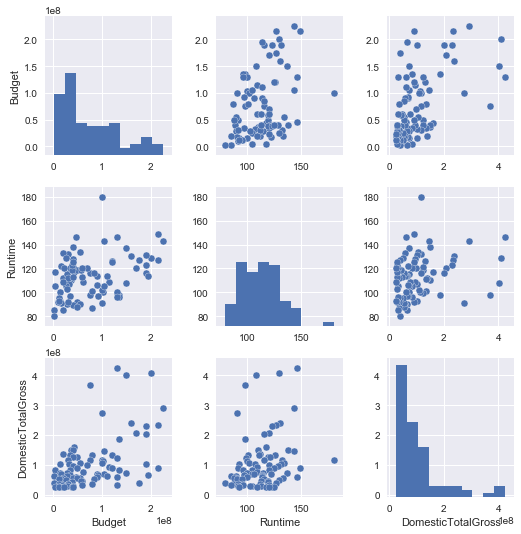

In [8]:
sns.pairplot(mv_df)

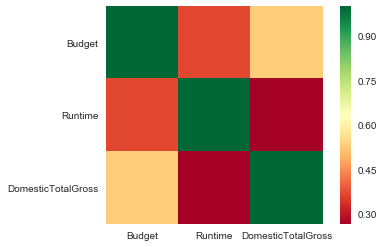

In [9]:
sns.heatmap(mv_df.corr(), square=True, cmap='RdYlGn')

In [10]:
mv_df['Constant'] = 1 #create a column with constant being 1

#fit a linear model that uses only the constant term (a column of 1) 
#target feature is a continuous outcome (domestic total gross)
q1 = smf.ols('DomesticTotalGross ~ Constant', data = mv_df)
model1 = q1.fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:     DomesticTotalGross   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                      -inf
Date:                Tue, 13 Feb 2018   Prob (F-statistic):                nan
Time:                        12:12:27   Log-Likelihood:                -1714.4
No. Observations:                  87   AIC:                             3431.
Df Residuals:                      86   BIC:                             3433.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.176e+07   4.72e+06     10.975      0.0

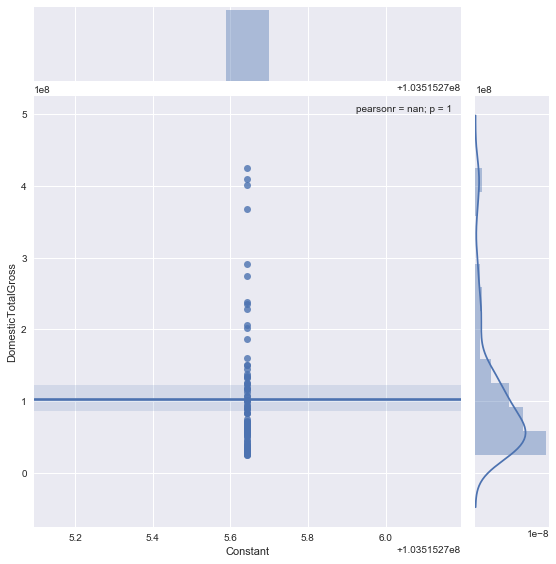

In [11]:
model1_pred = model1.predict(mv_df['Constant'])
sns.jointplot(x = model1_pred, y = mv_df['DomesticTotalGross'], kind='regplot', size = 8)
sns.set_context('talk')
plt.xlabel('Constant');

Text(0.5,1,'Residual Plot for Constant Term Model')

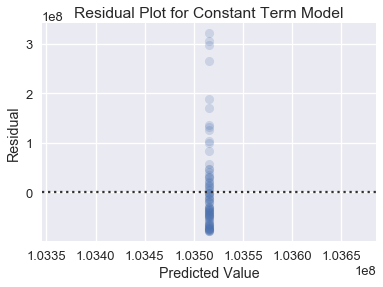

In [12]:
#residual plot
sns.residplot(x = model1_pred, y = mv_df['DomesticTotalGross']-model1_pred, data = mv_df, scatter_kws={'alpha':0.2})
plt.xlabel('Predicted Value')
plt.ylabel('Residual')
plt.title('Residual Plot for Constant Term Model')

Text(0.5,1,'Residual Histogram for Constant Term Model')

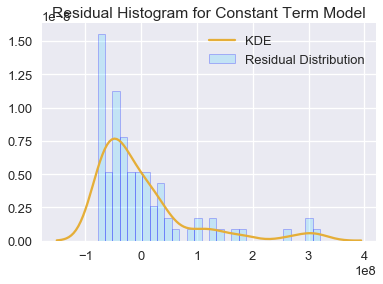

In [13]:
sns.distplot(mv_df['DomesticTotalGross']-model1_pred, bins = 30, 
             kde_kws = {'color': '#e5ae38', 'label': 'KDE'},
             hist_kws = {'alpha': 0.25, 
                         'label': 'Residual Distribution', 
                         'edgecolor':'b', 
                         'linewidth':1, 
                         'color':'#4dd2ff'})
plt.title('Residual Histogram for Constant Term Model')

**This linear model with only constant term (the intercept) is only predicting the average of the target feature. Such that any movie, at whatever genre, or budget or other features being ignored, such movie will likely have a Domestic Total Gross of $51,760,000.**

#### Challenge 2
Repeat the process of challenge one, but also add one continuous (numeric) predictor variable. Also add plots of model prediction against your feature variable and residuals against feature variable. How can you interpret what's happening in the model?

In [14]:
q2df = mv_df.copy()

In [15]:
model_2 = LinearRegression()
# Choose the predictor variables, here all but the first which is the response variable
X2 = q2df[['Budget', 'Constant']]
# Choose the response variable(s)
Y2 = q2df['DomesticTotalGross']
# Fit the model to the full dataset
model_2.fit(X2, Y2)
# Print out the R^2 for the model against the full dataset
model_2.score(X2, Y2)

0.28230037692954857

Text(0.5,1,'Residual Plot for 1-Var Term Model')

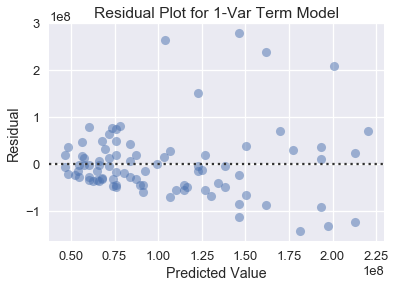

In [16]:
model2_pred = model_2.predict(X2)
sns.residplot(x = model2_pred, y = Y2-model2_pred, data = q2df, scatter_kws={'alpha':0.5})
sns.set_context('talk')
plt.xlabel('Predicted Value')
plt.ylabel('Residual')
plt.title('Residual Plot for 1-Var Term Model')

Text(41.025,0.5,'Actual (DomesticTotalGross)')

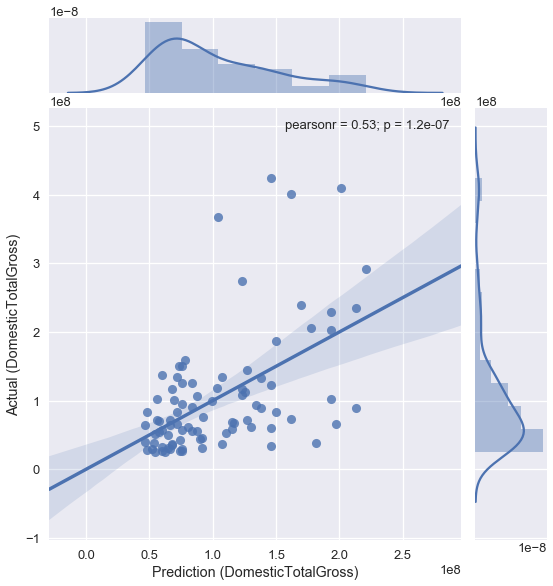

In [17]:
sns.jointplot(x = model2_pred, y = q2df['DomesticTotalGross'], kind='regplot', size = 8)
sns.set_context('talk')
plt.xlabel('Prediction (DomesticTotalGross)')
plt.ylabel('Actual (DomesticTotalGross)')

**The residual plot looks much more randomized by adding the non-constant feature to the model, the small p-values for the features indicates that all the included parameters are important for the model. skewness of dataset is high indicates non-normal distribution. The intercept value of 55005620.942 means that the predicted movie will have roughly 55005620.942 as domestic total gross when every other variables are 0, and the coefficient of the budget variable means that the domestic total gross is predicted to increase $0.635 per dollar budget for the movie, when other variables are held constant.**

#### Challenge 3
Repeat the process of challenge 1, but add a categorical feature (like genre). You'll have to convert a column of text into a number of numerical columns ("dummy variables"). How can you interpret what's happening in the model?

In [18]:
q3df = mv_df.copy()
q3df = pd.get_dummies(data = q3df, columns=['Rating'])
q3df.rename(columns={'Rating_PG-13':'Rating_PG13'},inplace=True)

model_3 = LinearRegression()
# Choose the predictor variables, here all but the first which is the response variable
X3 = q3df[['Rating_PG13', 'Rating_PG', 'Rating_R', 'Constant']]
# Choose the response variable(s)
Y3 = q3df['DomesticTotalGross']
# Fit the model to the full dataset
model_3.fit(X3, Y3)
# Print out the R^2 for the model against the full dataset
model_3.score(X3, Y3)

0.07166750327405913

Text(0.5,1,'Residual Plot for Constant+dummy Model')

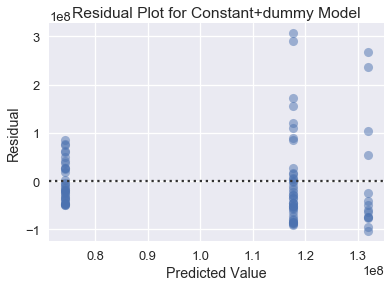

In [19]:
model3_pred = model_3.predict(X3)
sns.residplot(x = model3_pred, y = Y3-model3_pred, data = q3df, scatter_kws={'alpha':0.5})
sns.set_context('talk')
plt.xlabel('Predicted Value')
plt.ylabel('Residual')
plt.title('Residual Plot for Constant+dummy Model')

#### Challenge 4
Enhance your model further by adding more features and/or transforming existing features. Think about how you build the model matrix and how to interpret what the model is doing.

In [20]:
q4df = mv_df.copy()
q4df = pd.get_dummies(data = q4df, columns=['Rating'])
q4df.rename(columns={'Rating_PG-13':'Rating_PG13'},inplace=True)

model_4 = LinearRegression()
# Choose the predictor variables, here all but the first which is the response variable
X4 = q4df[['Budget', 'Constant', 'Rating_PG13', 'Rating_PG', 'Rating_R', 'Runtime']]
# Choose the response variable(s)
Y4 = q4df['DomesticTotalGross']
# Fit the model to the full dataset
model_4.fit(X4, Y4)
# Print out the R^2 for the model against the full dataset
model_4.score(X4, Y4)

0.29867705443266701

In [21]:
list(zip(X4.columns, model_4.coef_))

[('Budget', 0.69566065764357521),
 ('Constant', -1.1257361620664597e-07),
 ('Rating_PG13', -9676905.8783860486),
 ('Rating_PG', 17790723.176568262),
 ('Rating_R', -8113817.2981822006),
 ('Runtime', 625396.4069507781)]

Text(0.5,1,'Residual Plot for Multiple Feature Model')

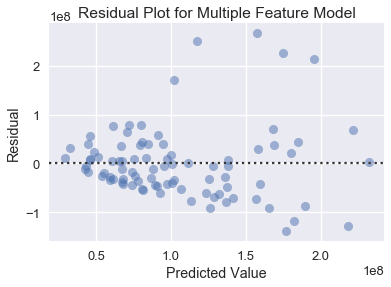

In [22]:
model4_pred = model_4.predict(X4)
sns.residplot(x = model4_pred, y = Y4-model4_pred, data = q4df, scatter_kws={'alpha':0.5})
sns.set_context('talk')
plt.xlabel('Predicted Value')
plt.ylabel('Residual')
plt.title('Residual Plot for Multiple Feature Model')

Text(41.025,0.5,'Actual (DomesticTotalGross)')

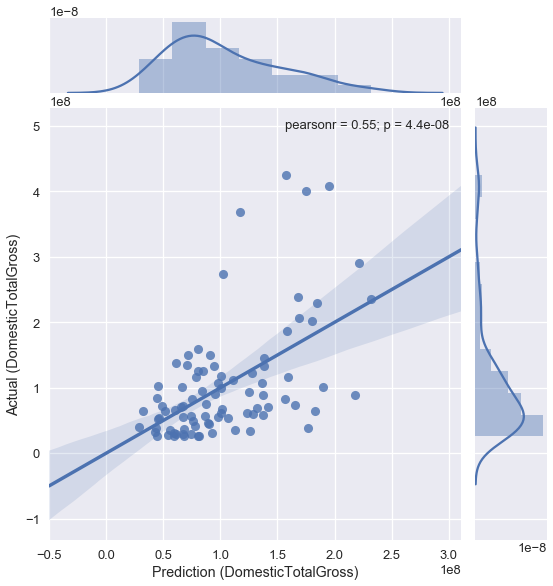

In [23]:
sns.jointplot(x = model4_pred, y = q4df['DomesticTotalGross'], kind='regplot', size = 8)
sns.set_context('talk')
plt.xlabel('Prediction (DomesticTotalGross)')
plt.ylabel('Actual (DomesticTotalGross)')

R^2 only increase about 0.01, meaning the addition of other variables other the budget contribute minimally to the predictive power. Residual plot still shows a slight funnel shape, some degree of collinearity is very likely within the data. 

#### Challenge 5
Fitting and checking predictions on the exact same data set can be misleading. Divide your data into two sets: a training and a test set (roughly 75% training, 25% test is a fine split). Fit a model on the training set, check the predictions (by plotting versus actual values) in the test set.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X4, Y4, test_size = 0.3, random_state = 2)

model_5 = LinearRegression()
model_5.fit(X_train,y_train)
model_5.score(X_test,y_test)

0.27469519494684336

Text(41.025,0.5,'Actual (DomesticTotalGross)')

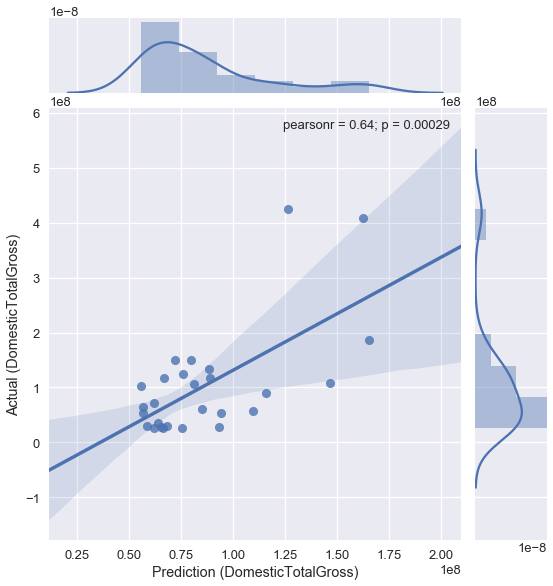

In [28]:
model5_pred = model_5.predict(X_test)
sns.jointplot(x = model5_pred, y = y_test, kind='regplot', size = 8)
sns.set_context('talk')
plt.xlabel('Prediction (DomesticTotalGross)')
plt.ylabel('Actual (DomesticTotalGross)')